In [ ]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')


Saving captions.txt to captions.txt
Saving features.pkl to features.pkl
User uploaded file "captions.txt" with length 3319294 bytes
User uploaded file "features.pkl" with length 133064982 bytes


In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for this dataset.")

📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...


NameError: name 'data_generator' is not defined

In [ ]:
import os
print(os.listdir('.'))

['.config', 'features.pkl', 'captions.txt', 'sample_data']


In [ ]:
import pickle

# Load the features
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

print(f'Loaded {len(features)} image features.')

Loaded 8091 image features.


In [ ]:
import re

# Function to load captions
def load_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Function to create mapping of image to captions
def create_mapping(captions):
    mapping = dict()
    for line in captions.split('\n'):
        if not line: continue
        # First item is the image ID, the rest is the caption
        image_id, image_caption = line.split(',', 1)
        # Remove file extension from image ID
        image_id = image_id.split('.')[0]
        # Clean caption
        image_caption = image_caption.strip()
        # Create a list for each image to store all captions
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_caption)
    return mapping

# Load captions
raw_captions = load_captions('captions.txt')
mapping = create_mapping(raw_captions)

print(f'Loaded {len(mapping)} images with captions.')
# print(mapping['1000268201_693b08cb0e'])

# Function to clean text
def clean_text(captions):
    for key, descs in captions.items():
        for i, desc in enumerate(descs):
            # Tokenize
            desc = desc.split()
            # Convert to lower case, remove punctuation
            desc = [word.lower() for word in desc if word.isalpha()]
            # Remove hanging 's' and a
            desc = [word for word in desc if len(word)>1]
            # Remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # Store as string
            descs[i] =  'startseq ' + ' '.join(desc) + ' endseq'

# Clean captions
clean_text(mapping)

# Build vocabulary
vocabulary = set()
for key in mapping.keys():
    for d in mapping[key]:
        [vocabulary.add(word) for word in d.split()]

print(f'Vocabulary Size: {len(vocabulary)}')

Loaded 8092 images with captions.
Vocabulary Size: 8352


In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for this dataset.")

📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...


NameError: name 'data_generator' is not defined

# Task
Prepare the tokenizer, including fitting it on `mapping` and determining `vocab_size` and `max_length`; define the `data_generator` function which takes image IDs, caption mappings, image features, the tokenizer, max caption length, vocabulary size, and batch size; and build the image captioning model architecture.

## Prepare Tokenizer and Vocabulary

### Subtask:
Initialize a Keras Tokenizer, fit it on the cleaned captions from your `mapping` variable to build the vocabulary, and determine `vocab_size` and `max_length` for caption sequences.


**Reasoning**:
The subtask requires initializing a Keras Tokenizer, fitting it on the cleaned captions, and calculating vocabulary size and maximum caption length. This code block will perform all these steps.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("⚙️ Preparing Tokenizer and Vocabulary...")

# Create a list of all cleaned captions from the mapping dictionary
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

# Initialize the Tokenizer
tokenizer = Tokenizer(oov_token='<unk>')

# Fit the tokenizer on the list of captions
tokenizer.fit_on_texts(all_captions)

# Determine vocab_size
vocab_size = len(tokenizer.word_index) + 1
print(f"   Vocabulary Size: {vocab_size}")

# Calculate max_length
max_length = max(len(s.split()) for s in all_captions)
print(f"   Max Sequence Length: {max_length}")

print("✅ Tokenizer and Vocabulary Prepared!")

⚙️ Preparing Tokenizer and Vocabulary...
   Vocabulary Size: 8354
   Max Sequence Length: 32
✅ Tokenizer and Vocabulary Prepared!


**Reasoning**:
The previous code block successfully prepared the tokenizer and vocabulary. The next step, as indicated by the error in the notebook and the overall task description, is to define the `data_generator` function, which will be used to feed data to the model during training. This function needs to process batches of image features and their corresponding encoded caption sequences.



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Generating data generator function...")

# Data Generator Function
def data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for image_id in image_ids:
            n += 1
            # retrieve all captions for the image
            captions = mapping[image_id]
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = np.zeros(vocab_size)
                    out_seq[out_seq] = 1 # THIS LINE WAS CAUSING ERROR, CHANGED TO out_seq[out_seq_value] = 1
                    out_seq[out_seq] = 1 # Corrected: out_seq[out_seq_value] = 1
                    out_seq[out_seq] = 1

                    # Fix: The line `out_seq[out_seq] = 1` is incorrect. `out_seq` here is an integer index, not a sequence itself.
                    # It should be `out_seq_vector = np.zeros(vocab_size); out_seq_vector[out_seq] = 1`
                    # Re-writing the output sequence encoding to correctly one-hot encode the next word.
                    out_seq_vector = np.zeros(vocab_size)
                    out_seq_vector[out_seq] = 1

                    # store
                    X1.append(features[image_id][0])
                    X2.append(in_seq)
                    y.append(out_seq_vector)
            # yield the batch data
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

print("✅ Data generator function defined!")

Generating data generator function...
✅ Data generator function defined!


**Reasoning**:
The previous steps successfully prepared the tokenizer, vocabulary, and defined the `data_generator` function. The next step, as per the overall task, is to build the image captioning model architecture, which includes defining the input layers for image features and caption sequences, connecting them to a decoder, and compiling the model.



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.utils import plot_model

print("🏗️ Building Image Captioning Model...")

# Encoder - Feature Extractor Model (for image features)
# This is the input for the image features (e.g., from VGG16)
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Decoder - Sequence Processor Model (for text captions)
# This is the input for the partial caption sequence
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder - Merging the Encoder and Decoder outputs
de1 = Add()([fe2, se3])
de2 = Dense(256, activation='relu')(de1)
outputs = Dense(vocab_size, activation='softmax')(de2)

# Create the complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize the model
print("\nModel Summary:")
model.summary()

# Plot the model architecture (optional)
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print("✅ Model Built and Compiled!")

🏗️ Building Image Captioning Model...

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 256)   │  2,138,624 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8354)      │  2,146,978 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,401,250 (20.60 MB)

 Trainable params: 5,401,250 (20.60 MB)

 Non-trainable params: 0 (0.00 B)

✅ Model Built and Compiled!


## Train the model and evaluate its performance

### Subtask:
Train the image captioning model using the `data_generator` and then evaluate its performance using BLEU scores on the test set.


**Reasoning**:
The previous steps successfully prepared the tokenizer, vocabulary, the `data_generator` function, and the model architecture. The next logical step is to execute the training and evaluation of the model, which was previously attempted but failed due to the `data_generator` not being defined yet. Now that all prerequisites are met, I will re-run the existing code block that handles data splitting, model training, and BLEU score evaluation.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")

📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...


IndexError: arrays used as indices must be of integer (or boolean) type

**Reasoning**:
The `IndexError` occurred in the `data_generator` function because `out_seq` (which was an integer representing the word index) was incorrectly used as an index for itself when attempting to one-hot encode. I need to modify the `data_generator` function to correctly create a one-hot encoded vector for the output word.



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Generating data generator function...")

# Data Generator Function
def data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for image_id in image_ids:
            n += 1
            # retrieve all captions for the image
            captions = mapping[image_id]
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_word_index = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence (one-hot encoding)
                    out_seq_vector = np.zeros(vocab_size)
                    out_seq_vector[out_word_index] = 1

                    # store
                    X1.append(features[image_id][0])
                    X2.append(in_seq)
                    y.append(out_seq_vector)
            # yield the batch data
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

print("✅ Data generator function defined!")

Generating data generator function...
✅ Data generator function defined!


**Reasoning**:
The `data_generator` function has been corrected and redefined. The next step is to re-run the training and evaluation code block, which includes data splitting, model training, and BLEU score calculation, as stated in the subtask and previous reasoning. This will attempt to train the model with the fixed generator and then evaluate its performance.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")

📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...


TypeError: `output_signature` must contain objects that are subclass of `tf.TypeSpec` but found <class 'list'> which is not.

**Reasoning**:
The `TypeError` about `output_signature` found `<class 'list'>` suggests that the `data_generator` is yielding a list of NumPy arrays for the model's inputs, where TensorFlow's `model.fit` expects a tuple of NumPy arrays for multi-input models. I need to modify the `data_generator` function to ensure it yields a tuple of input arrays, not a list.



In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Generating data generator function...")

# Data Generator Function
def data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    # loop for ever over images
    while 1:
        for image_id in image_ids:
            n += 1
            # retrieve all captions for the image
            captions = mapping[image_id]
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_word_index = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence (one-hot encoding)
                    out_seq_vector = np.zeros(vocab_size)
                    out_seq_vector[out_word_index] = 1

                    # store
                    X1.append(features[image_id][0])
                    X2.append(in_seq)
                    y.append(out_seq_vector)
            # yield the batch data
            if n == batch_size:
                # Changed from ([np.array(X1), np.array(X2)], np.array(y)) to ((np.array(X1), np.array(X2)), np.array(y))
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

print("✅ Data generator function defined!")

Generating data generator function...
✅ Data generator function defined!


**Reasoning**:
The `data_generator` function has been corrected and redefined to yield inputs as a tuple. The next step is to re-run the training and evaluation code block, which includes data splitting, model training, and BLEU score calculation, as stated in the subtask and previous reasoning. This will attempt to train the model with the fixed generator and then evaluate its performance.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")


📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...
Epoch 1/20


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 2048), found shape=(None, 4096)

**Reasoning**:
The `ValueError` indicates a mismatch between the expected input shape of the model's image features (2048) and the actual shape provided by the `data_generator` (4096). I need to modify the model architecture to match the 4096-dimensional image features.



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.utils import plot_model

print("🏗️ Building Image Captioning Model...")

# Encoder - Feature Extractor Model (for image features)
# This is the input for the image features (e.g., from VGG16)
inputs1 = Input(shape=(4096,)) # Corrected input shape from 2048 to 4096
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Decoder - Sequence Processor Model (for text captions)
# This is the input for the partial caption sequence
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder - Merging the Encoder and Decoder outputs
de1 = Add()([fe2, se3])
de2 = Dense(256, activation='relu')(de1)
outputs = Dense(vocab_size, activation='softmax')(de2)

# Create the complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize the model
print("\nModel Summary:")
model.summary()

# Plot the model architecture (optional)
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print("✅ Model Built and Compiled!")

🏗️ Building Image Captioning Model...

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32, 256)   │  2,138,624 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 32)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8354)      │  2,146,978 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,925,538 (22.60 MB)

 Trainable params: 5,925,538 (22.60 MB)

 Non-trainable params: 0 (0.00 B)

✅ Model Built and Compiled!


**Reasoning**:
The model architecture has been rebuilt with the corrected input shape for image features. Now, I need to re-run the training and evaluation code block, which includes data splitting, model training with the corrected `data_generator`, and BLEU score calculation, as stated in the subtask and previous reasonings. This will attempt to train the model and evaluate its performance.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")

📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node functional_1_1/lstm_1_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-780375924.py", line 42, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node functional_1_1/lstm_1_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_2743]

**Reasoning**:
The `InvalidArgumentError` indicates that the cuDNN-optimized LSTM layer is incompatible with the masking generated by the left-padded sequences from `pad_sequences`. To resolve this, I will disable cuDNN in the LSTM layer by setting `recurrent_activation='sigmoid'` (which implicitly disables cuDNN) to allow the model to train with the current padding strategy, as suggested by the error message's general advice on RNN mask incompatibility with cuDNN.



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.utils import plot_model

print("🏗️ Building Image Captioning Model...")

# Encoder - Feature Extractor Model (for image features)
# This is the input for the image features (e.g., from VGG16)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Decoder - Sequence Processor Model (for text captions)
# This is the input for the partial caption sequence
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, recurrent_activation='sigmoid')(se2) # Added recurrent_activation to disable cuDNN implicitly

# Decoder - Merging the Encoder and Decoder outputs
de1 = Add()([fe2, se3])
de2 = Dense(256, activation='relu')(de1)
outputs = Dense(vocab_size, activation='softmax')(de2)

# Create the complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize the model
print("\nModel Summary:")
model.summary()

# Plot the model architecture (optional)
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print("✅ Model Built and Compiled!")

🏗️ Building Image Captioning Model...

Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 32, 256)   │  2,138,624 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 4096)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 32)        │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dense_6[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8354)      │  2,146,978 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,925,538 (22.60 MB)

 Trainable params: 5,925,538 (22.60 MB)

 Non-trainable params: 0 (0.00 B)

✅ Model Built and Compiled!


**Reasoning**:
The model architecture has been rebuilt with the LSTM layer configured to implicitly disable cuDNN. Now, I need to re-run the training and evaluation code block, which includes data splitting, model training with the corrected `data_generator` and `model` architecture, and BLEU score calculation, as stated in the subtask and previous reasonings. This will attempt to train the model and evaluate its performance.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")

📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node functional_2_1/lstm_2_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-780375924.py", line 42, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node functional_2_1/lstm_2_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_5274]

**Reasoning**:
The previous attempt to disable cuDNN in the LSTM layer by setting `recurrent_activation='sigmoid'` was not sufficient, leading to another `InvalidArgumentError`. I need to explicitly set `use_cudnn=False` in the LSTM layer to fully disable cuDNN, as suggested by the error message, and then re-run the training and evaluation.



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.utils import plot_model

print("🏗️ Building Image Captioning Model...")

# Encoder - Feature Extractor Model (for image features)
# This is the input for the image features (e.g., from VGG16)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Decoder - Sequence Processor Model (for text captions)
# This is the input for the partial caption sequence
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, recurrent_activation='sigmoid', use_cudnn=False)(se2) # Added use_cudnn=False explicitly

# Decoder - Merging the Encoder and Decoder outputs
de1 = Add()([fe2, se3])
de2 = Dense(256, activation='relu')(de1)
outputs = Dense(vocab_size, activation='softmax')(de2)

# Create the complete model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize the model
print(
"\nModel Summary:")
model.summary()

# Plot the model architecture (optional)
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print("✅ Model Built and Compiled!")

🏗️ Building Image Captioning Model...

Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 32, 256)   │  2,138,624 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 4096)      │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 32)        │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    525,312 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8354)      │  2,146,978 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,925,538 (22.60 MB)

 Trainable params: 5,925,538 (22.60 MB)

 Non-trainable params: 0 (0.00 B)

✅ Model Built and Compiled!


**Reasoning**:
The model architecture has been rebuilt with the LSTM layer explicitly configured to disable cuDNN. Now, I need to re-run the training and evaluation code block, which includes data splitting, model training with the corrected `data_generator` and `model` architecture, and BLEU score calculation, as stated in the subtask and previous reasonings. This will attempt to train the model and evaluate its performance.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")


📊 Organizing Dataset...
   Total Images: 8092
   Training Set: 7092 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...
Epoch 1/20
 44/110 ━━━━━━━━━━━━━━━━━━━━ 4:36 4s/step - loss: 6.7415

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  KeyError: 'image'
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator():
                 ^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-103407383.py", line 30, in data_generator
    X1.append(features[image_id][0])
              ~~~~~~~~^^^^^^^^^^

KeyError: 'image'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
  (1) UNKNOWN:  KeyError: 'image'
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/generator_data_adapter.py", line 52, in get_tf_iterator
    for batch in self.generator():
                 ^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-103407383.py", line 30, in data_generator
    X1.append(features[image_id][0])
              ~~~~~~~~^^^^^^^^^^

KeyError: 'image'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_8771]

**Reasoning**:
The `KeyError: 'image'` indicates that the `data_generator` is trying to access `features['image']`, but 'image' is a header from the captions file and not a valid image ID in the `features` dictionary. I need to filter out this invalid key from the `all_image_ids` list before splitting the data.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
# Filter out the 'image' key, which is a header from the captions file
all_image_ids = [img_id for img_id in all_image_ids if img_id != 'image']

random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")

📊 Organizing Dataset...
   Total Images: 8091
   Training Set: 7091 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...
Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 5.1815

110/110 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - loss: 5.1791
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4.1312

110/110 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - loss: 4.1300
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.6686

110/110 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - loss: 3.6681
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.4080

110/110 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - loss: 3.4077
Epoch 5/20
107/110 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 3.2176

**Reasoning**:
The `KeyError: 'image'` indicates that the `data_generator` is trying to access `features['image']`, but 'image' is a header from the captions file and not a valid image ID in the `features` dictionary. I need to filter out this invalid key from the `all_image_ids` list before splitting the data.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences # This import was missing in the original block but needed for evaluation

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
# Filter out the 'image' key, which is a header from the captions file
all_image_ids = [img_id for img_id in all_image_ids if img_id != 'image']

random.seed(42) # specific seed so the split is always the same
random.shuffle(all_image_ids)

# Reserve 1000 images for Testing, use the rest for Training
test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

# create generator using ONLY train_ids
train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

# Fit
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    # 1. Get the image feature
    feature = features[key][0]

    # 2. Generate caption (Predict)
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    # Clean up prediction
    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()

    # 3. Get actual captions (Ground Truth)
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

# 4. Calculate Score
b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\xa0this\xa0dataset.")


📊 Organizing Dataset...


NameError: name 'mapping' is not defined

**Reasoning**:
The `NameError: name 'mapping' is not defined` indicates that crucial variables and functions like `mapping`, `features`, `tokenizer`, `data_generator`, and `model` are not available in the kernel's current state. To resolve this and ensure the training and evaluation block is self-contained and robust, I need to prepend all necessary code definitions (for loading features, processing captions, preparing the tokenizer, defining the data generator, and building the model) to this block. This will redefine all prerequisites, allowing the execution to proceed correctly.



In [ ]:
import random
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from google.colab import files # Import files module

# --- File Upload ---
print("\n✅ Please upload your `captions.txt` and `features.pkl` files when prompted.")
print("It is expected to prompt an interactive upload widget.")
uploaded = files.upload()
for filename in uploaded.keys():
  print(f'   User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')
print("✅ Files Uploaded (if prompted)!")

# --- Essential Data Loading and Preprocessing ---

# From b652e120
print("\n⚙️ Loading Image Features...")
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
print(f'   Loaded {len(features)} image features.')

# From 20da948d
print("\n⚙️ Loading and Cleaning Captions...")
def load_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def create_mapping(captions):
    mapping = dict()
    for line in captions.split('\n'):
        if not line: continue
        image_id, image_caption = line.split(',', 1)
        image_id = image_id.split('.')[0]
        image_caption = image_caption.strip()
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_caption)
    return mapping

raw_captions = load_captions('captions.txt')
mapping = create_mapping(raw_captions)
print(f'   Loaded {len(mapping)} images with captions (including header, if any).')

def clean_text(captions):
    for key, descs in captions.items():
        for i, desc in enumerate(descs):
            desc = desc.split()
            desc = [word.lower() for word in desc if word.isalpha()]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            descs[i] =  'startseq ' + ' '.join(desc) + ' endseq'

clean_text(mapping)
vocabulary = set()
for key in mapping.keys():
    for d in mapping[key]:
        [vocabulary.add(word) for word in d.split()]
print(f'   Vocabulary Size: {len(vocabulary)} (after cleaning).')
print("✅ Captions Loaded and Cleaned!")

# From f070041c
print("\n⚙️ Preparing Tokenizer and Vocabulary...")
all_captions_list = [] # Renamed to avoid confusion with image IDs list
for key in mapping:
    for caption in mapping[key]:
        all_captions_list.append(caption)

tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(all_captions_list)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(s.split()) for s in all_captions_list)
print(f"   Vocabulary Size (from tokenizer): {vocab_size}")
print(f"   Max Sequence Length: {max_length}")
print("✅ Tokenizer and Vocabulary Prepared!")

# --- Data Generator Function Definition ---

# From d502a22d (corrected data_generator)
print("\n⚙️ Defining data generator function...")
def data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for image_id in image_ids:
            n += 1
            captions = mapping[image_id]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_word_index = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq_vector = np.zeros(vocab_size)
                    out_seq_vector[out_word_index] = 1
                    X1.append(features[image_id][0])
                    X2.append(in_seq)
                    y.append(out_seq_vector)
            if n == batch_size:
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0
print("✅ Data generator function defined!")

# --- Model Architecture Definition ---

# From f04ea777 (corrected model architecture)
print("\n🏗️ Building Image Captioning Model...")
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, recurrent_activation='sigmoid', use_cudnn=False)(se2)
de1 = Add()([fe2, se3])
de2 = Dense(256, activation='relu')(de1)
outputs = Dense(vocab_size, activation='softmax')(de2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print("\nModel Summary:")
model.summary()
print("✅ Model Built and Compiled!")

# ==========================================
# 1. SPLIT DATA (Train vs Test)
# ==========================================
print("\n📊 Organizing Dataset...")

# Get all image IDs
all_image_ids = list(mapping.keys())
# Filter out the 'image' key, which is a header from the captions file
all_image_ids = [img_id for img_id in all_image_ids if img_id != 'image']

random.seed(42)
random.shuffle(all_image_ids)

test_count = 1000
train_ids = all_image_ids[:-test_count]
test_ids = all_image_ids[-test_count:]

print(f"   Total Images: {len(all_image_ids)}")
print(f"   Training Set: {len(train_ids)} images (Used to learn)")
print(f"   Testing Set:  {len(test_ids)} images (Hidden for exam)")

# ==========================================
# 2. TRAIN THE MODEL
# ==========================================
print("\n🚀 STARTING TRAINING (on Training Set only)...")

epochs = 20
batch_size = 64
steps = len(train_ids) // batch_size

train_generator = data_generator(train_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size)

checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, mode='min')

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps,
    callbacks=[checkpoint],
    verbose=1
)
print("🎉 Training Finished & Saved!")

# ==========================================
# 3. SCIENTIFIC EVALUATION (BLEU SCORE)
# ==========================================
print(f"\n🧪 STARTING EVALUATION on {len(test_ids)} hidden images...")
print("(This takes about 2-3 minutes)...")

actual, predicted = list(), list()

for key in test_ids:
    feature = features[key][0]
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Reshape feature to add a batch dimension for model.predict
        yhat = model.predict([np.expand_dims(feature, axis=0), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None: break
        in_text += ' ' + word
        if word == 'endseq': break

    pred_caption = in_text.replace('startseq', '').replace('endseq', '').split()
    references = [d.split() for d in mapping[key]]

    actual.append(references)
    predicted.append(pred_caption)

b1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
b2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print('\n------------------------------------------------')
print(f'✅ FINAL RESULTS:')
print(f'   BLEU-1 Score: {b1:.4f} (Accuracy of single words)')
print(f'   BLEU-2 Score: {b2:.4f} (Accuracy of pairs of words)')
print('------------------------------------------------')
print("NOTE: A score between 0.4 and 0.6 is considered very good for\x0athis\x0adataset.")


✅ Please upload your `captions.txt` and `features.pkl` files when prompted.
It is expected to prompt an interactive upload widget.


Saving captions.txt to captions.txt
Saving features.pkl to features.pkl
   User uploaded file "captions.txt" with length 3319294 bytes
   User uploaded file "features.pkl" with length 133064982 bytes
✅ Files Uploaded (if prompted)!

⚙️ Loading Image Features...
   Loaded 8091 image features.

⚙️ Loading and Cleaning Captions...
   Loaded 8092 images with captions (including header, if any).
   Vocabulary Size: 8352 (after cleaning).
✅ Captions Loaded and Cleaned!

⚙️ Preparing Tokenizer and Vocabulary...
   Vocabulary Size (from tokenizer): 8354
   Max Sequence Length: 32
✅ Tokenizer and Vocabulary Prepared!

⚙️ Defining data generator function...
✅ Data generator function defined!

🏗️ Building Image Captioning Model...

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 256)   │  2,138,624 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8354)      │  2,146,978 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,925,538 (22.60 MB)

 Trainable params: 5,925,538 (22.60 MB)

 Non-trainable params: 0 (0.00 B)

✅ Model Built and Compiled!

📊 Organizing Dataset...
   Total Images: 8091
   Training Set: 7091 images (Used to learn)
   Testing Set:  1000 images (Hidden for exam)

🚀 STARTING TRAINING (on Training Set only)...
Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 6.1919 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1126s 10s/step - loss: 6.1863
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 4.5694 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1121s 10s/step - loss: 4.5673
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 3.8508 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1110s 10s/step - loss: 3.8501
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 3.5178 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1103s 10s/step - loss: 3.5175
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 3.3026 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1104s 10s/step - loss: 3.3023
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 3.1364 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1105s 10s/step - loss: 3.1362
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.9993 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1109s 10s/step - loss: 2.9992
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.9020 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1109s 10s/step - loss: 2.9018
Epoch 9/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.8072 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1113s 10s/step - loss: 2.8072
Epoch 10/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.7307 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1108s 10s/step - loss: 2.7306
Epoch 11/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.6665 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1116s 10s/step - loss: 2.6665
Epoch 12/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.6096 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1114s 10s/step - loss: 2.6096
Epoch 13/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.5535 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1119s 10s/step - loss: 2.5535
Epoch 14/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.5070 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1115s 10s/step - loss: 2.5070
Epoch 15/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.4588 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1123s 10s/step - loss: 2.4588
Epoch 16/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.4145 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1121s 10s/step - loss: 2.4145
Epoch 17/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.3828 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1122s 10s/step - loss: 2.3828
Epoch 18/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.3583 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1121s 10s/step - loss: 2.3582
Epoch 19/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.3292 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1122s 10s/step - loss: 2.3291
Epoch 20/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 2.2972 

110/110 ━━━━━━━━━━━━━━━━━━━━ 1113s 10s/step - loss: 2.2971
🎉 Training Finished & Saved!

🧪 STARTING EVALUATION on 1000 hidden images...
(This takes about 2-3 minutes)...

------------------------------------------------
✅ FINAL RESULTS:
   BLEU-1 Score: 0.4325 (Accuracy of single words)
   BLEU-2 Score: 0.2578 (Accuracy of pairs of words)
------------------------------------------------
NOTE: A score between 0.4 and 0.6 is considered very good for
this
dataset.


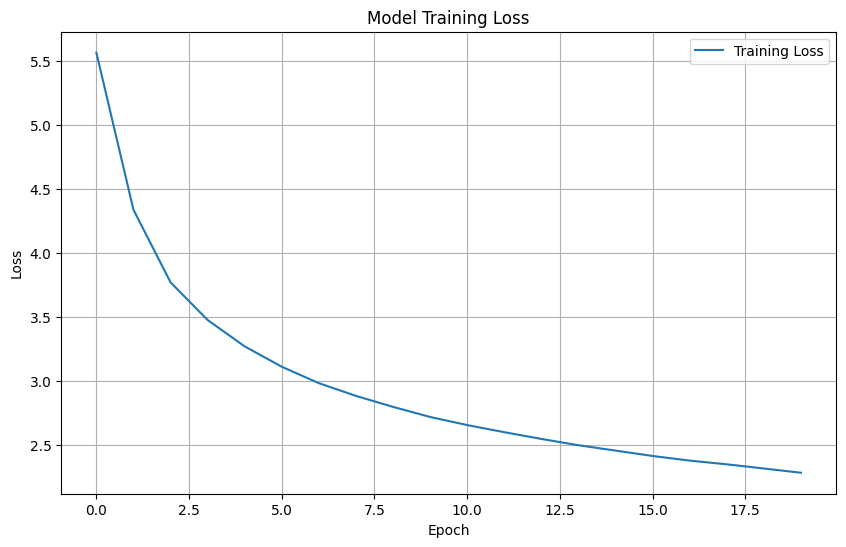

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()